<a href="https://colab.research.google.com/github/sleepyllie/sleepyllie/blob/main/jan17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import pandas as pd
import numpy as np


In [2]:
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE265nnn/GSE265753/suppl/GSE265753_processed_counts_matrix.csv.gz
!gunzip GSE265753_processed_counts_matrix.csv.gz


--2026-01-17 19:47:15--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE265nnn/GSE265753/suppl/GSE265753_processed_counts_matrix.csv.gz
           => ‘GSE265753_processed_counts_matrix.csv.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE265nnn/GSE265753/suppl ... done.
==> SIZE GSE265753_processed_counts_matrix.csv.gz ... 529951815
==> PASV ... done.    ==> RETR GSE265753_processed_counts_matrix.csv.gz ... done.
Length: 529951815 (505M) (unauthoritative)

GSE265753_processed 100%[===================>] 505.40M  38.8MB/s    in 6.8s    

2026-01-17 19:47:22 (74.2 MB/s) - ‘GSE265753_processed_counts_matrix.csv.gz’ saved [529951815]



In [3]:
!ls -lh


total 14G
-rw-r--r-- 1 root root  14G Jan 17 19:47 GSE265753_processed_counts_matrix.csv
drwxr-xr-x 1 root root 4.0K Dec 11 14:34 sample_data


In [4]:
!!head -n 1 GSE265753_processed_counts_matrix.csv

['"","KHS_024_sc_15411","KHS_024_sc_9292089","KHS_024_sc_5928969","KHS_024_sc_9300516","KHS_024_sc_7969589","KHS_024_sc_13434251","KHS_024_sc_1630530","KHS_024_sc_3539334","KHS_024_sc_9893814","KHS_024_sc_5626418","KHS_024_sc_8995253","KHS_024_sc_5613783","KHS_024_sc_23514","KHS_024_sc_6783433","KHS_024_sc_11820342","KHS_024_sc_7529932","KHS_024_sc_9737094","KHS_024_sc_3262876","KHS_024_sc_10477510","KHS_024_sc_9018674","KHS_024_sc_3252576","KHS_024_sc_4892599","KHS_024_sc_9744040","KHS_024_sc_1360572","KHS_024_sc_7235366","KHS_024_sc_1645070","KHS_024_sc_13448928","KHS_024_sc_8586656","KHS_024_sc_3271718","KHS_024_sc_8862358","KHS_024_sc_9890711","KHS_024_sc_10505556","KHS_024_sc_3570103","KHS_024_sc_3257563","KHS_024_sc_4307764","KHS_024_sc_1655461","KHS_024_sc_6503840","KHS_024_sc_8138928","KHS_024_sc_7243839","KHS_024_sc_10780471","KHS_024_sc_9023669","KHS_024_sc_1052938","KHS_024_sc_9883827","KHS_024_sc_6803782","KHS_024_sc_7246877","KHS_024_sc_7530319","KHS_024_sc_7979953","KHS_0

In [5]:
csv_path = "GSE265753_processed_counts_matrix.csv"
keep_patients = ["KHS_024", "KHS_032", "Control_1", "Control_2"]
cells_per_patient = 5
subset_genes = 500  # first 500 genes

# -------------------------------
# Step 1: Find 5 cells per patient from header (fast)
# -------------------------------
with open(csv_path, "r") as f:
    reader = csv.reader(f)
    header = next(reader)  # first row = column names

patient_cols = {p: [] for p in keep_patients}
for idx, col in enumerate(header[1:]):  # skip gene name column
    for p in keep_patients:
        if p in col and len(patient_cols[p]) < cells_per_patient:
            patient_cols[p].append(idx + 1)  # +1 because first column is gene names

# Columns to load = gene column + selected cells
keep_cols = [0] + [i for sublist in patient_cols.values() for i in sublist]
print(f"Loading {len(keep_cols)-1} cells (5 per patient) and first {subset_genes} genes...")

# -------------------------------
# Step 2: Load only those columns & first 500 genes
# -------------------------------
data = []
gene_names = []

with open(csv_path, "r") as f:
    reader = csv.reader(f)
    header = next(reader)  # skip header
    for i, row in enumerate(reader):
        if i >= subset_genes:
            break
        gene_names.append(row[0])
        data.append([row[j] for j in keep_cols[1:]])  # selected cells only

# Convert to DataFrame: cells x genes
X = np.array(data, dtype=np.float32).T  # transpose so rows = cells
cell_names = [header[j] for j in keep_cols[1:]]
df_T = pd.DataFrame(X, index=cell_names, columns=gene_names)

# -------------------------------
# Step 3: Extract patient ID
# -------------------------------
df_T["patient_id"] = df_T.index.str.split("_").str[:2].str.join("_")
print(df_T["patient_id"].value_counts())


Loading 20 cells (5 per patient) and first 500 genes...
patient_id
KHS_024      5
KHS_032      5
Control_1    5
Control_2    5
Name: count, dtype: int64


In [8]:
# GETTING THE TOTAL PATIENTS/CONTROLS IN THE BIG CSV.
# GETTING PATIENT IDS.
csv_path = "GSE265753_processed_counts_matrix.csv"

with open(csv_path, "r") as f:
    reader = csv.reader(f)
    header = next(reader)  # first row = column names

# Skip the first column (gene names)
cell_names = header[1:]

# Extract patient IDs from cell barcodes
# Assumes cell names are like "KHS_024_cell123"
patient_ids = set("_".join(name.split("_")[:2]) for name in cell_names)

print(f"Total number of patients/controls in CSV: {len(patient_ids)}")
print("Example patient IDs:", list(patient_ids)[:18])


Total number of patients/controls in CSV: 18
Example patient IDs: ['KHS_001', 'Control_1', 'KHS_026', 'Control_2', 'KHS_022', 'KHS_029', 'KHS_032', 'KHS_007', 'KHS_048', 'KHS_049', 'KHS_008', 'KHS_044', 'KHS_047', 'KHS_046', 'KHS_034', 'KHS_043', 'KHS_045', 'KHS_024']


In [9]:
CELLS_PER_PATIENT = 300

from collections import defaultdict

cells_by_patient = defaultdict(list)

for col in cell_names:
    pid = "_".join(col.split("_")[:2])
    cells_by_patient[pid].append(col)

# Select balanced cells
selected_cells = []
for pid, cells in cells_by_patient.items():
    selected_cells.extend(cells[:CELLS_PER_PATIENT])

print("Patients included:", len(set("_".join(c.split("_")[:2]) for c in selected_cells)))
print("Total selected cells:", len(selected_cells))


Patients included: 18
Total selected cells: 5400


In [13]:
df = pd.read_csv(
    csv_path,
    nrows=500,
    usecols=["Unnamed: 0"] + selected_cells,
    index_col=0
)


In [12]:
import pandas as pd

subset_genes = 500      # first 500 genes
subset_cells = 5000

csv_path = "GSE265753_processed_counts_matrix.csv"

# Load only 100 genes × 50 cells
df = pd.read_csv(
    csv_path,
    nrows=subset_genes,
    usecols=list(range(subset_cells + 1)),
    index_col=0
)
print("Gene expression subset shape (genes x cells):", df.shape)

# ROWS: GENES. COLUMNS: SINGLE CELLS. Values = raw UMI counts


KeyboardInterrupt: 

In [14]:
import numpy as np

df_T = df.T
print("Cells × Genes shape:", df_T.shape)
df_T.head()

# Extract patient ID from cell barcode
df_T["patient_id"] = (
    df_T.index
    .str.split("_")
    .str[:2]
    .str.join("_")
)
#df_T['patient_id'] = df_T.index.str.extract(r'^(KHS_\d+|Control_\d+)', expand=False)
df_T["patient_id"].head(10)

# Check result: shoudl give patient id from each cellbarcode.
df_T[['patient_id']].value_counts().head(10)


Cells × Genes shape: (5400, 500)


patient_id
Control_1     300
Control_2     300
KHS_001       300
KHS_007       300
KHS_008       300
KHS_022       300
KHS_024       300
KHS_026       300
KHS_029       300
KHS_032       300
Name: count, dtype: int64

In [15]:
# Aggregate by patient: If a patient has multiple cells, take the mean expression per gene:
X_patient = df_T.groupby('patient_id').mean()

print("Patients × Genes shape:", X_patient.shape)
X_patient.head()


Patients × Genes shape: (18, 500)


A1BG  A1BG-AS1      A1CF       A2M   A2M-AS1     A2ML1  \
patient_id                                                               
Control_1   0.246667  0.176667  0.006667  0.023333  0.053333  0.000000   
Control_2   0.113333  0.113333  0.000000  0.023333  0.046667  0.006667   
KHS_001     0.160000  0.110000  0.000000  0.023333  0.060000  0.000000   
KHS_007     0.130000  0.056667  0.000000  0.036667  0.050000  0.003333   
KHS_008     0.130000  0.083333  0.000000  0.056667  0.086667  0.006667   

            A2ML1-AS1  A2ML1-AS2   A3GALT2    A4GALT  ...  AC005520.5  \
patient_id                                            ...               
Control_1    0.013333   0.003333  0.020000  0.000000  ...    0.013333   
Control_2    0.010000   0.000000  0.010000  0.003333  ...    0.023333   
KHS_001      0.006667   0.000000  0.006667  0.003333  ...    0.023333   
KHS_007      0.023333   0.000000  0.010000  0.006667  ...    0.010000   
KHS_008      0.006667   0.000000  0.003333  0.000000  ...    0.013333   

            AC005522.1  AC005523.1  AC005523.2  AC005534.1  AC005537.1  \
patient_id                                                               
Control_1          0.0    0.003333    0.006667    0.010000    0.010000   
Control_2          0.0    0.000000    0.003333    0.010000    0.003333   
KHS_001            0.0    0.003333    0.003333    0.006667    0.003333   
KHS_007            0.0    0.000000    0.016667    0.020000    0.003333   
KHS_008            0.0    0.003333    0.010000    0.020000    0.000000   

            AC005538.1  AC005540.1  AC005544.1  AC005546.1  
patient_id                                                  
Control_1     0.003333    0.003333         0.0    0.003333  
Control_2     0.000000    0.023333         0.0    0.003333  
KHS_001       0.000000    0.003333         0.0    0.006667  
KHS_007       0.000000    0.000000         0.0    0.010000  
KHS_008       0.000000    0.003333         0.0    0.000000  

[5 rows x 500 columns]

In [16]:
# Create labels
def label_from_patient(pid):
    return 0 if pid.lower().startswith("control") else 1

X_patient["label"] = X_patient.index.map(label_from_patient)

X = np.log1p(X_patient.drop(columns="label"))
y = X_patient["label"]
# Sanity check
y.value_counts()


label
1    16
0     2
Name: count, dtype: int64

In [17]:
from scipy.stats import ttest_ind

cases = X[y == 1]
controls = X[y == 0]

pvals = []
for gene in X.columns:
    _, p = ttest_ind(cases[gene], controls[gene], equal_var=False)
    pvals.append(p)

de_genes = pd.Series(pvals, index=X.columns).sort_values()
de_genes.head(20)


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


AC005393.1    7.234528e-10
ABI3          3.088574e-07
ABCG5         5.225409e-07
AC004973.1    1.164870e-06
ABHD14A       4.796731e-06
AC004223.3    5.991078e-05
AC004231.1    1.133302e-04
ABCF2         2.706420e-04
AC002451.1    3.027379e-04
AC005324.4    3.370466e-04
AC002996.1    5.062928e-04
ABHD17A       5.992916e-04
ABT1          7.530398e-04
AC004702.1    9.147925e-04
ABHD4         1.006397e-03
ABCG1         1.093357e-03
AC004492.1    1.131466e-03
AC004593.3    1.427004e-03
AC003666.1    1.501774e-03
AC004852.2    3.192890e-03
dtype: float64

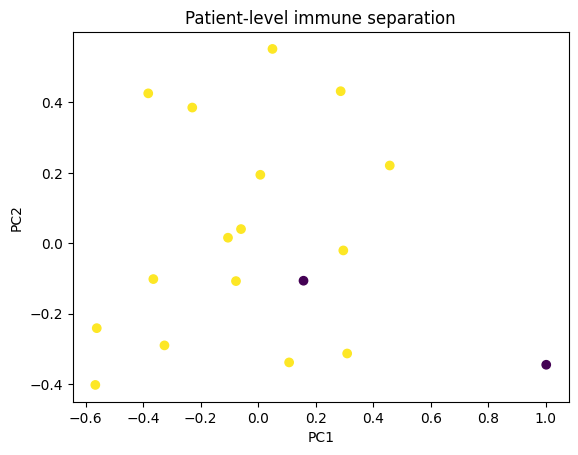

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_pca = PCA(n_components=2).fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Patient-level immune separation")
plt.show()


CELL ID EXAMPLE: KHS_024_sc_15411
- Patient Name: KHS_024
- Cell Barcode: sc_15411

## **SERIES MATRIX LOADING**
- using wget + remember to use ! to access commands.

In [ ]:
# Download the series matrix directly from GEO
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE265nnn/GSE265753/matrix/GSE265753_series_matrix.txt.gz

# Unzip it
!gunzip GSE265753_series_matrix.txt.gz


--2026-01-11 18:11:39--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE265nnn/GSE265753/matrix/GSE265753_series_matrix.txt.gz
           => ‘GSE265753_series_matrix.txt.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE265nnn/GSE265753/matrix ... done.
==> SIZE GSE265753_series_matrix.txt.gz ... 2394
==> PASV ... done.    ==> RETR GSE265753_series_matrix.txt.gz ... done.
Length: 2394 (2.3K) (unauthoritative)

GSE265753_series_ma 100%[===================>]   2.34K  9.34KB/s    in 0.3s    

2026-01-11 18:11:44 (9.34 KB/s) - ‘GSE265753_series_matrix.txt.gz’ saved [2394]



In [ ]:
series_path = "GSE265753_series_matrix.txt"

# Store characteristics per sample
sample_characteristics = {}
sample_ids = []

with open(series_path, "r") as f:
    for line in f:
        line = line.strip()
        if line.startswith("!Sample_title"):
            sample_ids = [s.strip().strip('"') for s in line.split("\t")[1:subset_cells+1]]
        elif line.startswith("!Sample_characteristics_ch1"):
            char_strings = [s.strip().strip('"') for s in line.split("\t")[1:subset_cells+1]]
            for i, s in enumerate(char_strings):
                if ":" in s:
                    key, value = s.split(":", 1)
                    key = key.strip().replace(" ", "_")
                    value = value.strip()
                    if key not in sample_characteristics:
                        sample_characteristics[key] = [""] * len(sample_ids)
                    sample_characteristics[key][i] = value

In [ ]:
# Try to get Long COVID status
long_covid_keys = [k for k in sample_characteristics.keys() if "Long_COVID" in k or "covid_status" in k.lower()]
if long_covid_keys:
    chosen_key = next((k for k in long_covid_keys if k == "Long_COVID"), long_covid_keys[0])
    labels = sample_characteristics[chosen_key]
else:
    print("Warning: No Long_COVID characteristic found. Using dummy labels.")
    labels = ["Unknown_Status"] * len(sample_ids)

# Convert to DataFrame and align with cells
labels_df = pd.DataFrame(labels, columns=["Long_COVID_status"], index=sample_ids)


In [ ]:
# 1️⃣ Transpose and aggregate cells → patients
df_T = df.T  # cells × genes

# Extract patient IDs from cell barcodes (e.g., KHS_024_sc_15411 → KHS_024)
df_T["patient_id"] = df_T.index.str.extract(r'^(KHS_\d+|Control_\d+)')

# Aggregate by patient: mean expression across all cells
X_patient = df_T.groupby("patient_id").mean()
print("Aggregated Patients × Genes shape:", X_patient.shape)

# 2️⃣ Create labels per patient
# Function to convert patient ID → Long COVID label
def label_from_patient(pid):
    return 0 if pid.lower().startswith("control") else 1

labels = pd.DataFrame({
    "Long_COVID_status": [label_from_patient(pid) for pid in X_patient.index]
}, index=X_patient.index)

# 3️⃣ Merge labels with aggregated expression
X_patient["Long_COVID_status"] = labels["Long_COVID_status"]
print("\nMerged patient-level dataset ready for CNN:")
print(X_patient.head())
print("Shape:", X_patient.shape)


KeyError: "None of [Index(['Multiplexing set 1, Whole transcriptome analysis library (WTA), scRNAseq',\n       'Multiplexing set 1, Sample Tag library (ST), scRNAseq',\n       'Multiplexing set 2, Whole transcriptome analysis and Sample Tag (ST) libraries, scRNAseq',\n       'Multiplexing set 3, Sample Tag library (ST), scRNAseq',\n       'Multiplexing set 3, Whole transcriptome analysis library (WTA), scRNAseq',\n       'Multiplexing set 4, Sample Tag library (ST), scRNAseq',\n       'Multiplexing set 4, Whole transcriptome analysis library (WTA), scRNAseq',\n       'Multiplexing set 5, Sample Tag library (ST), scRNAseq',\n       'Multiplexing set 5, Whole transcriptome analysis library (WTA), scRNAseq',\n       'Multiplexing set 6, Sample Tag library (ST), scRNAseq',\n       'Multiplexing set 6, Whole transcriptome analysis library (WTA), scRNAseq',\n       'Multiplexing set 7, Sample Tag library (ST), scRNAseq',\n       'Multiplexing set 7, Whole transcriptome analysis library (WTA), scRNAseq'],\n      dtype='object')] are in the [index]"

In [ ]:
import pandas as pd

# Path to your series matrix file
series_matrix_path = "/content/GSE265753_series_matrix.txt"

unique_characteristics = {} # To store unique characteristic key -> set of values

with open(series_matrix_path, "r") as f:
    for line in f:
        line = line.strip()
        if line.startswith("!Sample_characteristics_ch1"):
            # Split by tab, skip the first element (!Sample_characteristics_ch1)
            char_strings = [s.strip().strip('"') for s in line.strip().split('\t')[1:]]

            for char_str in char_strings:
                if ":" in char_str:
                    key, value = char_str.split(":", 1)
                    key = key.strip().replace(" ", "_") # Normalize key (e.g., "Long COVID" -> "Long_COVID")
                    value = value.strip()

                    if key not in unique_characteristics:
                        unique_characteristics[key] = set()
                    unique_characteristics[key].add(value)

print("Found unique characteristic mappings:")
for key, values_set in unique_characteristics.items():
    print(f"'{key}': {', '.join(sorted(list(values_set)))} ")


Found unique characteristic mappings:
'tissue': Peripheral whole blood 
'samples_(multiplexed)': Control_1, KHS_001_sc, KHS_001_v4, KHS_007_sc, KHS_007_v4, Control_2, KHS_008_sc, KHS_008_v4, KHS_034_sc, KHS_034_v4, KHS_022_sc, KHS_022_v4, KHS_026_sc, KHS_026_v4, KHS_029_sc, KHS_024_sc, KHS_032_sc, KHS_043_sc, KHS_048_sc, KHS_049_sc, KHS_024_v4, KHS_032_v4, KHS_043_v4, KHS_048_v4, KHS_049_v4, KHS_029_v4, KHS_046_sc, KHS_046_v4, KHS_047_sc, KHS_047_v4, KHS_044_sc, KHS_044_v4, KHS_045_sc, KHS_045_v4, KHS_010_v5 
